# Functions for RNA-seq analysis

## 0. Read csv 

In [45]:
# Read_count("count.csv")
Read_count <- function(input){
    data <- read.csv(input, as.is=T, header=T)
    if(length(which(duplicated(data[,1])))>0){
        data <- data[-which(duplicated(data[,1])),]
    }
    rownames(data) <- data[,1]
    data <- data[,-1]
    return(data)
}

In [46]:
data <- Read_count("count.csv")
head(data)

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,sample11,sample12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
DDX11L1,0,0,1,0,0,0,0,0,1,0,0,0
WASH7P,288,451,304,431,322,310,188,165,178,289,220,273
MIR6859-1,5,4,8,6,6,9,5,1,4,2,3,11
MIR1302-2HG,1,1,0,0,1,0,0,0,0,0,0,1
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0


## 1. grouping

In [47]:
# Input_count_csv("FileName.csv", Grouplist (c("group1","group1".....,"group2","group2"....))
Grouping <- function(data, GroupList) {
    group <- sort(GroupList)
    names(GroupList) <- colnames(data)
    GroupList <- sort(GroupList)
    data <- data[, names(GroupList)]
    return(data)
}

In [48]:
group <- c(rep("group1",6),rep("group2",6))
data <- Grouping(data, group)
group <-　sort(group)

## 2. Filtering

In [49]:
# Remove row expressing gene
Filtering <- function(data, criteria) {
    HighExpGene <- as.logical(rowSums(data) > criteria)
    output <- unique(data[HighExpGene,])
    return(output)
}

In [50]:
data <- Filtering(data, 0)

## 3. Normalization (cpm)

In [51]:
# Normalization by cpm
Normalization <- function(data, TotalRead) {
    NormFactor <- TotalRead/colSums(data)
    output <- sweep(data, 2, NormFactor, "*")
    return(output)
}

In [52]:
data <- Normalization(data,1000000)

## 4.  Clustering

In [53]:
Clustering <- function(data){
    data.dist <- as.dist(1 - cor(data, method="spearman"))
    out_cluster <- hclust(data.dist,method="average")
    plot(out_cluster)
}

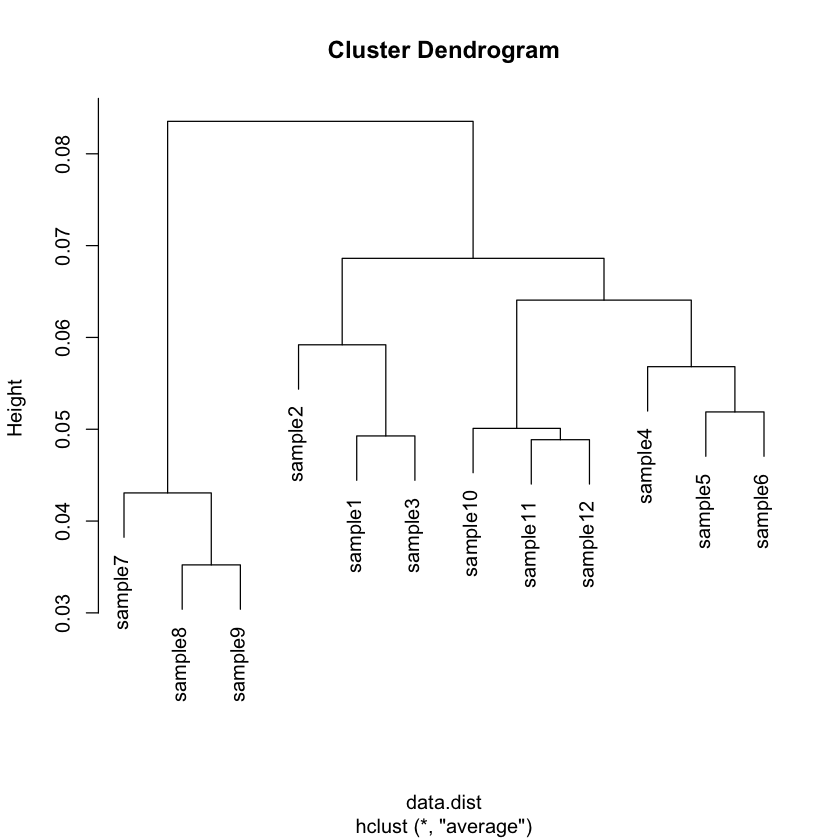

In [54]:
Clustering(data)

## 5. PCA 

In [55]:
PCA <- function(data, group){
    pca<-prcomp(t(data))
    col <- ifelse(group=="group1","blue","red")
    # principal component 
    plot(pca, main="PCA")
    # PC1 x PC2
    plot(pca$x[,c(1,2)], type='n')
    text(pca$x[,c(1,2)],label=colnames(data),col=col ,cex=0.8)
    # PC1 x PC3
    plot(pca$x[,c(1,3)], type='n')
    text(pca$x[,c(1,3)],label=colnames(data),col=col ,cex=0.8)
    # PC2 x PC3
    plot(pca$x[,c(2,3)], type='n')
    text(pca$x[,c(2,3)],label=colnames(data),col=col ,cex=0.8)
}

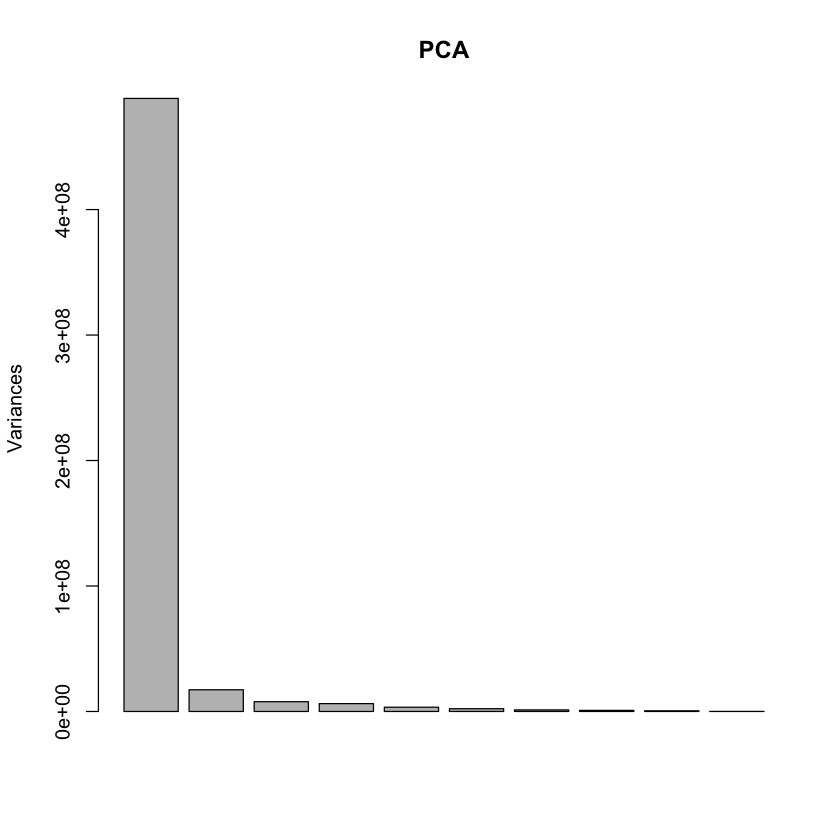

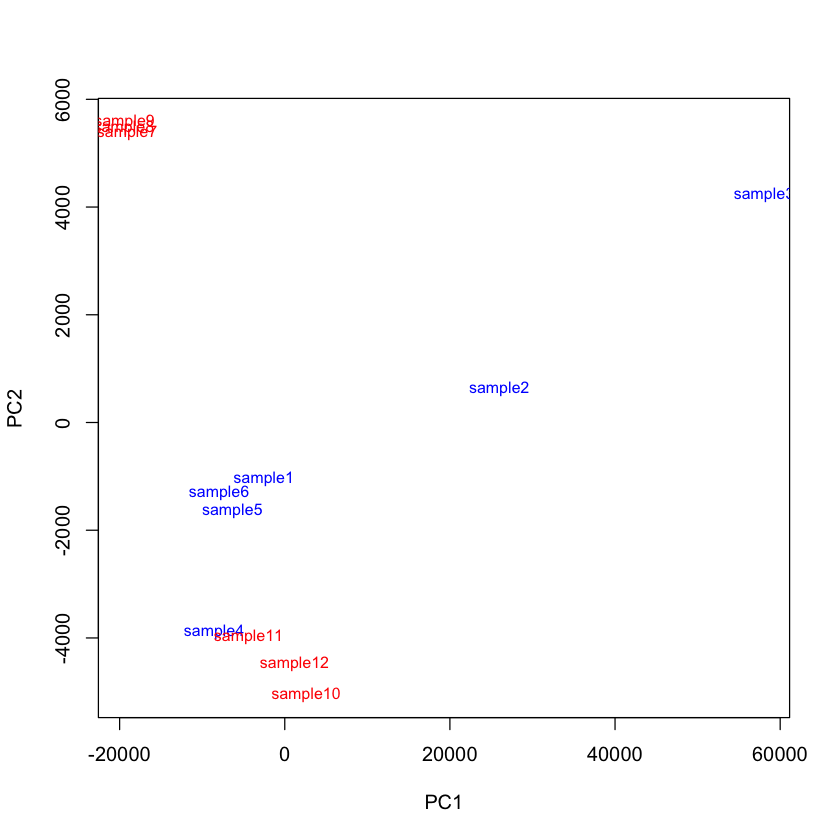

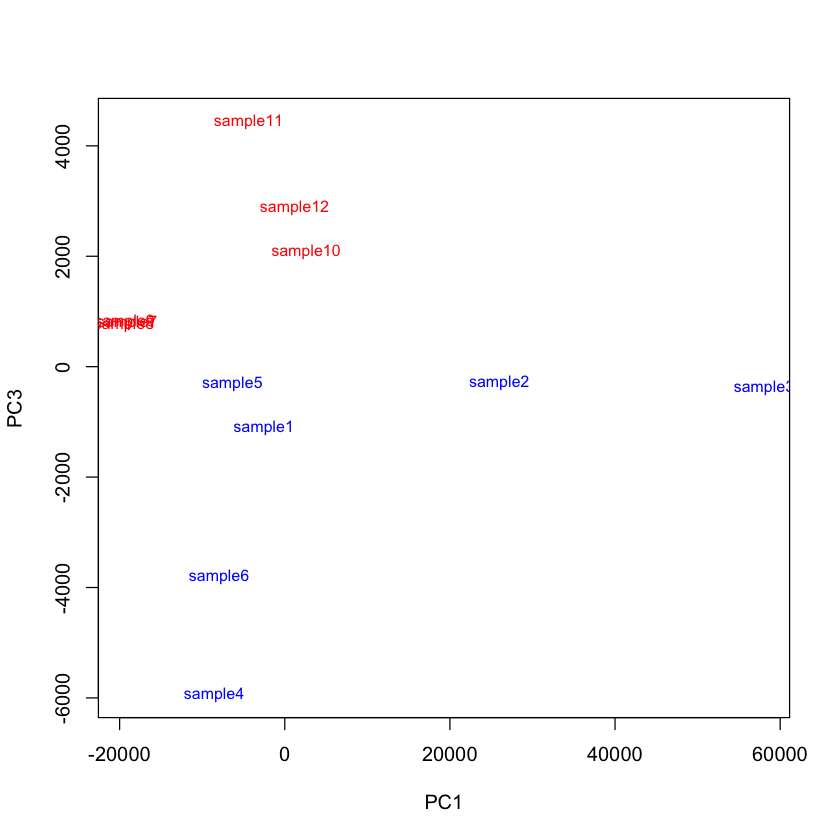

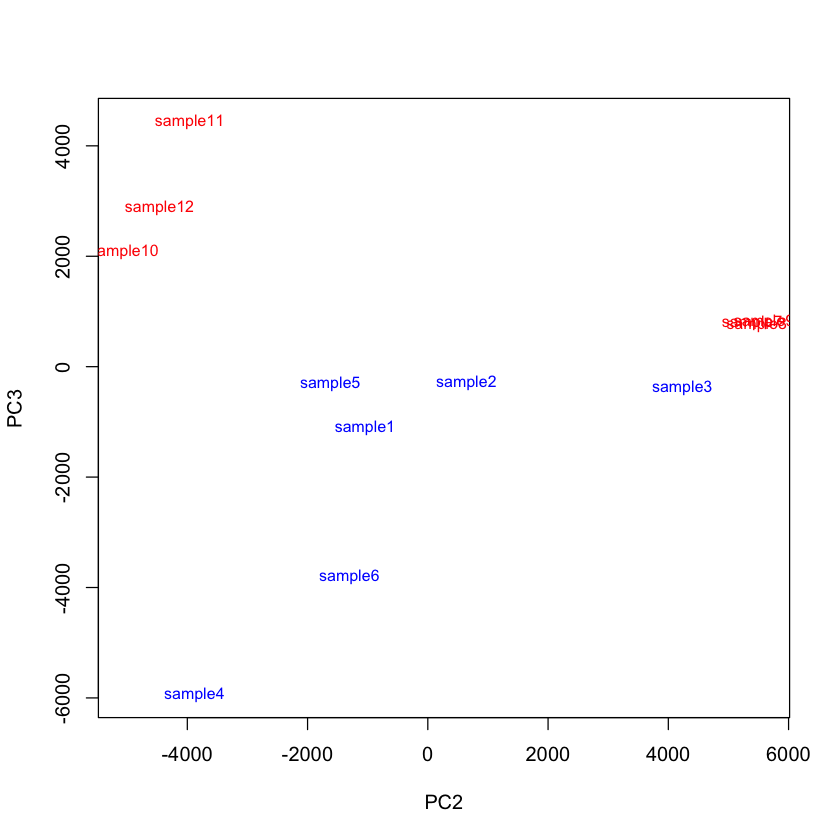

In [56]:
PCA(data, group)

## 6. DEG

In [60]:
DEG <- function(data, group, FDR, FCcriteria, UPorDown){
    require(edgeR)
    param_G1 <- sum(group==unique(group)[1])
    param_G2 <- sum(group==unique(group)[2])
    groupnum <- c(rep(1, param_G1), rep(2, param_G2))
    #DEG
    d <- DGEList(counts=data,group=groupnum) #create DEGlist object
    d <- calcNormFactors(d) #TMM normalization
    norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors) #normalization factor
    ef.libsizes <- colSums(data)*norm.factors
    normalized.count <- sweep(data, 2, mean(ef.libsizes)/ef.libsizes, "*")
    d <- estimateCommonDisp(d) #calculate common dispersion by qCML
    d <- estimateTagwiseDisp(d) #calculate moderated tagwise dispersion by qCML 
    out <- exactTest(d) #extract DEGs by exact test
    p.value <- out$table$PValue
    q.value <- p.adjust(p.value, method="BH")
    logFC <- out$table$logFC
    FC <- 2^logFC
    ranking <- rank(p.value)
    tmp <- cbind(rownames(data), normalized.count, p.value, q.value,logFC,FC,ranking) # integrated result file
    upDEG <- rownames(tmp[which((tmp$q.value < FDR) & (tmp$FC > FCcriteria)),])
    downDEG <- rownames(tmp[which((tmp$q.value < FDR) & (tmp$FC < (1/FCcriteria))),])
    if(UPorDown == "up"){
        return(upDEG)
    }else if(UPorDown == "down"){
        return(downDEG)
    }else{
        print("usage: DEG(data, group, FDR, 'up' or 'down')")
    }
}

In [61]:
upDEG <- DEG(data, group, 0.05, 1,  'up')
downDEG <- DEG(data, group, 0.05, 1, 'down')

## 7. MA plot

In [62]:
MAplot <- function(data, group, FDR, FCcriteria){
    require(edgeR)
    param_G1 <- sum(group==unique(group)[1])
    param_G2 <- sum(group==unique(group)[2])
    groupnum <- c(rep(1, param_G1), rep(2, param_G2))
    #DEG
    D <- DGEList(counts=data,group=groupnum) #create DEGlist object
    D <- calcNormFactors(D) #TMM normalization
    #calculate q.value
    d <- estimateCommonDisp(D) #calculate common dispersion by qCML
    d <- estimateTagwiseDisp(d) #calculate moderated tagwise dispersion by qCML 
    out <- exactTest(d) #extract DEGs by exact test
    p.value <- out$table$PValue
    q.value <- p.adjust(p.value, method="BH")
    logFC <- out$table$logFC
    FC <- 2^logFC
    #MAplot
    norm_f_TMM <- D$samples$norm.factors #extract TMM normalization factor
    names(norm_f_TMM) <- colnames(data)
    effective_libsizes <- colSums(data) * norm_f_TMM#effective library sizes = library sizes*TMM normalization factor
    RPM_TMM <- sweep(data, 2, 1000000/effective_libsizes, "*")
    DATA <- RPM_TMM
    mean_G1 <- log2(apply(as.matrix(DATA[,groupnum==1]), 1, mean))
    mean_G2 <- log2(apply(as.matrix(DATA[,groupnum==2]), 1, mean))
    x_axis <- (mean_G1 + mean_G2)/2
    y_axis <- mean_G2 - mean_G1
    DEG_posi_up <- (q.value < FDR & FC > FCcriteria)
    DEG_posi_down <- (q.value < FDR & FC < (1/FCcriteria))
    #draw plot
    plot(x_axis, y_axis, xlab="A=(log2(G2)+log2(G1))/2", ylab="M=log2(G2)-log2(G1)", pch=20, cex=.1)#drow MA-plot
    points(x_axis[DEG_posi_up], y_axis[DEG_posi_up], col="red", pch=20, cex=1)
    points(x_axis[DEG_posi_down], y_axis[DEG_posi_down], col="blue", pch=20, cex=1)
}


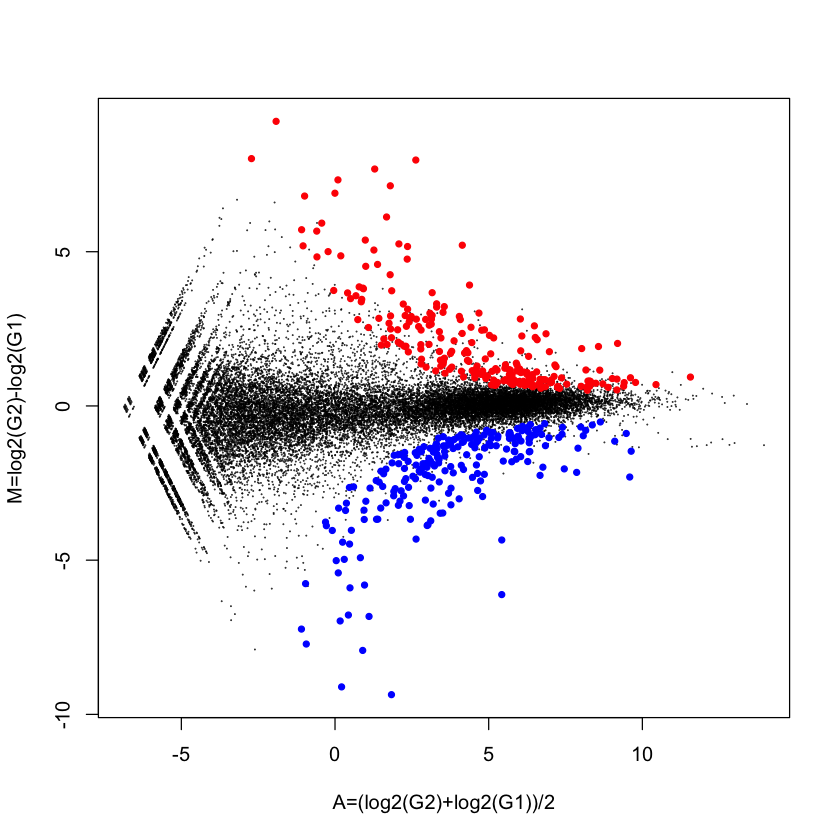

In [63]:
MAplot(data, group, 0.05,1)

## 8. Heatmap

In [64]:
DrawHeatmap <- function(data, group, upDEG, downDEG){
    require(ComplexHeatmap)
    mat <- data[c(upDEG,downDEG),]
    mat <- log2(mat+1)
    mat <- mat-rowMeans(mat)

    annotation = HeatmapAnnotation(
        df = data.frame(group=group),
        col=list(group=c(group1="blue","group2"="red")),
        gap = unit(1, "mm"),
        show_annotation_name = FALSE,
        annotation_name_side="left",
        gp=gpar(col="white")
    )

    Heatmap(
        mat,
        name = "color",
        cluster_rows=FALSE,
        show_row_names = FALSE,
        top_annotation = annotation,
        row_names_side ="right",
        column_dend_height= unit(5, "cm"),
        gap = unit(3, "mm"),
        split = c(rep("upDEGs", length(upDEG)),rep("downDEGs", length(downDEG)))
    )
}

Warning message:
“The input is a data frame, convert it to the matrix.”


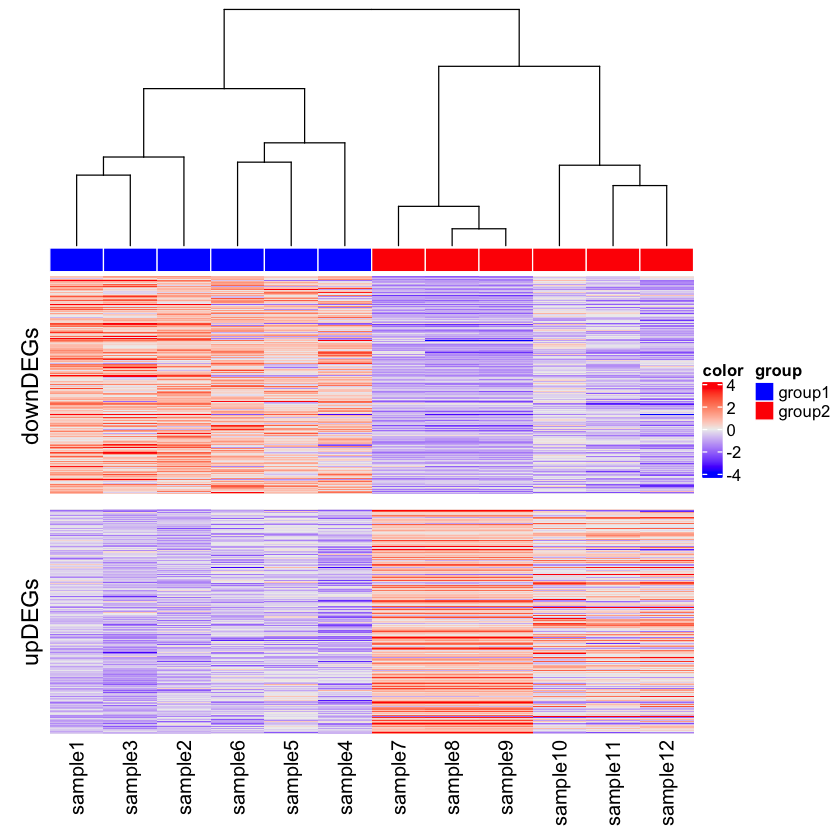

In [65]:
DrawHeatmap(data, group, upDEG, downDEG)

## 9. GO

In [66]:
GO <- function(DEG, species){
    require(gprofiler2)
    gostres <- gost(DEG, correction_method = "false_discovery_rate",sources = c("GO", "KEGG", "REAC"),evcodes = TRUE,organism = species)
    if(length(gostres)>0){
        g<-data.frame(gostres$result$query_size,gostres$result$intersection_size,gostres$result$p_value,gostres$result$term_id,gostres$result$source,gostres$result$term_name,gostres$result$intersection)
        colnames(g)<-sub("gostres.result.","",colnames(g))
        g<-g[order(g$p_value),]
        rownames(g)<-NULL
        p <- gostplot(gostres,interactive=F,capped=F)
        publish_gostplot(p,highlight_terms=head(g$term_id,20))
    }else{
        print("Not detected.")
    }
}


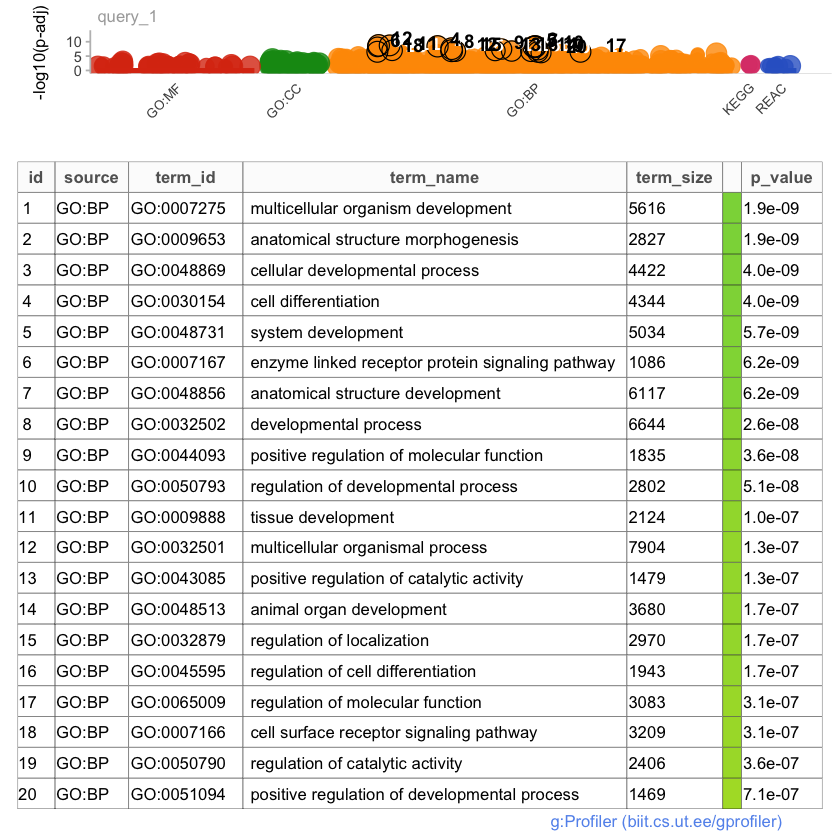

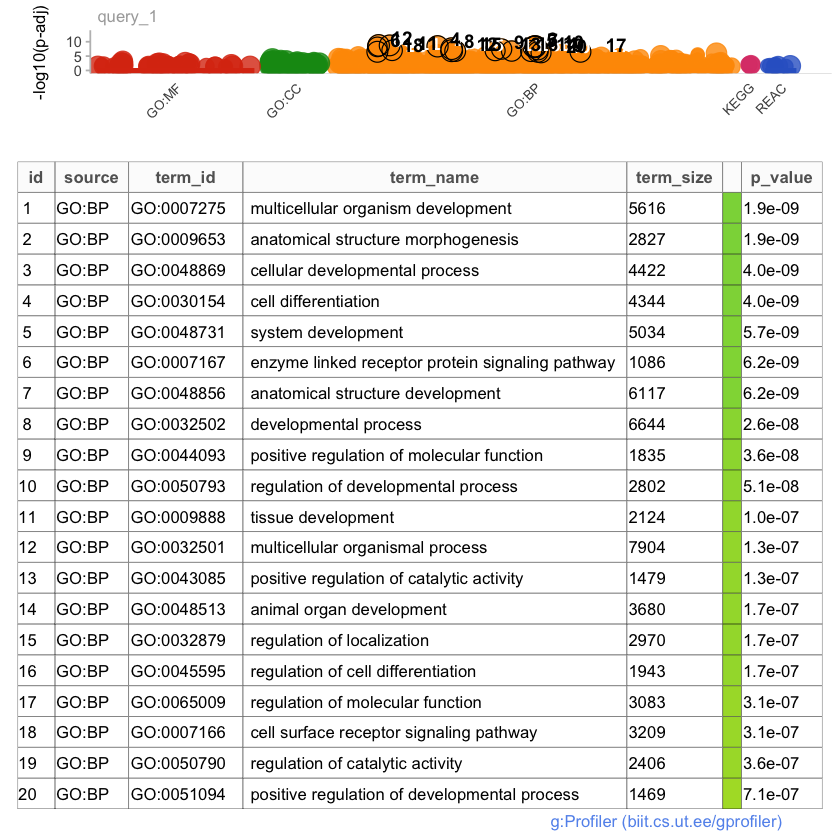

In [67]:
GO(upDEG, "hsapiens")

# Examples for analysis workflow (mouse.ver)

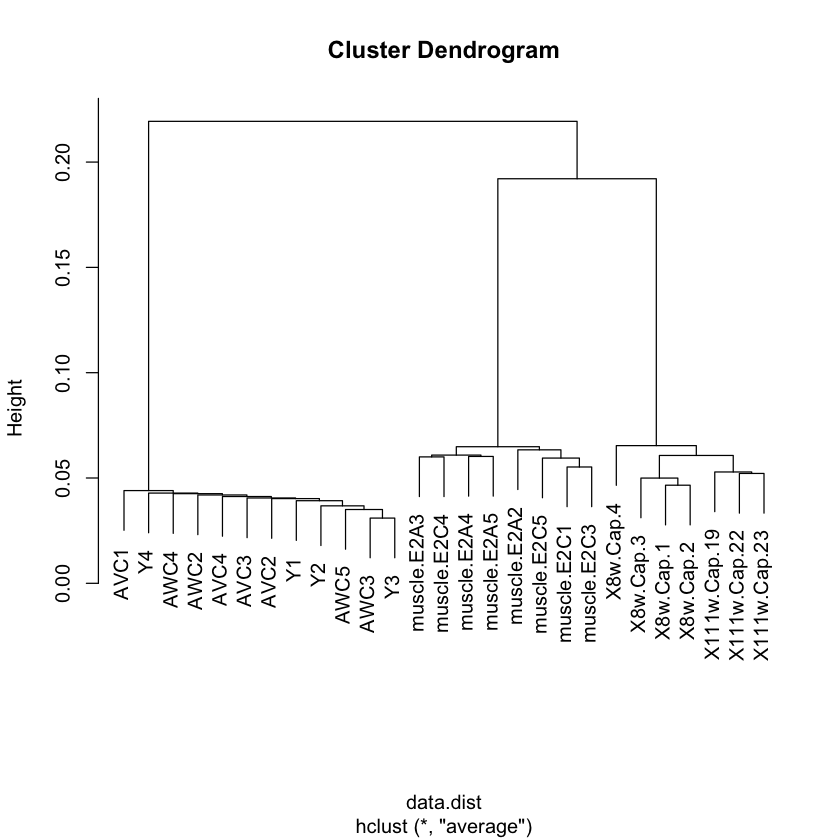

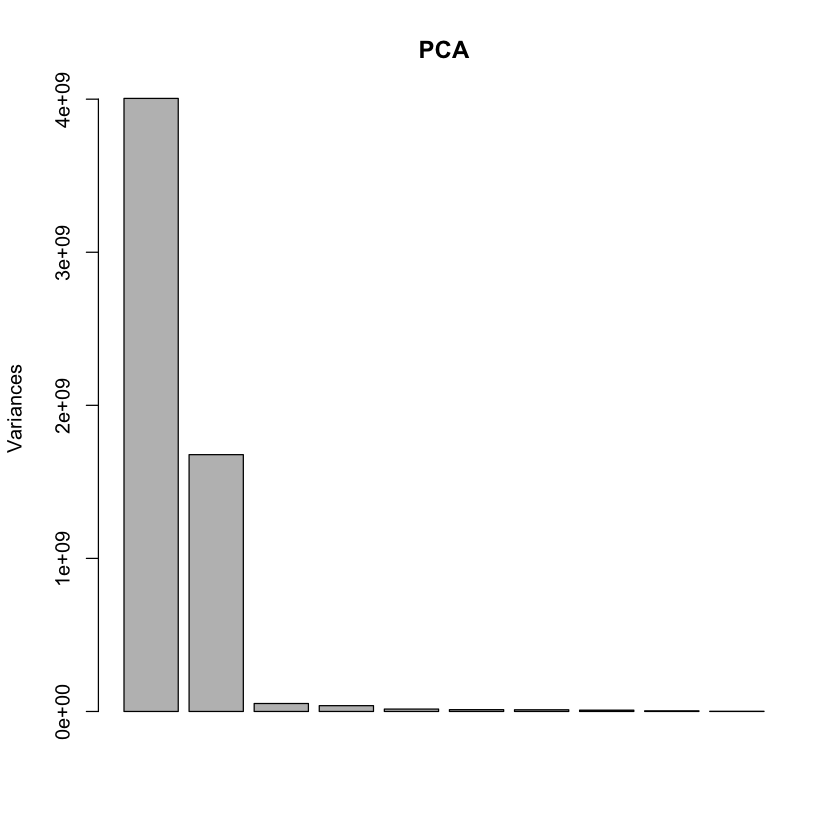

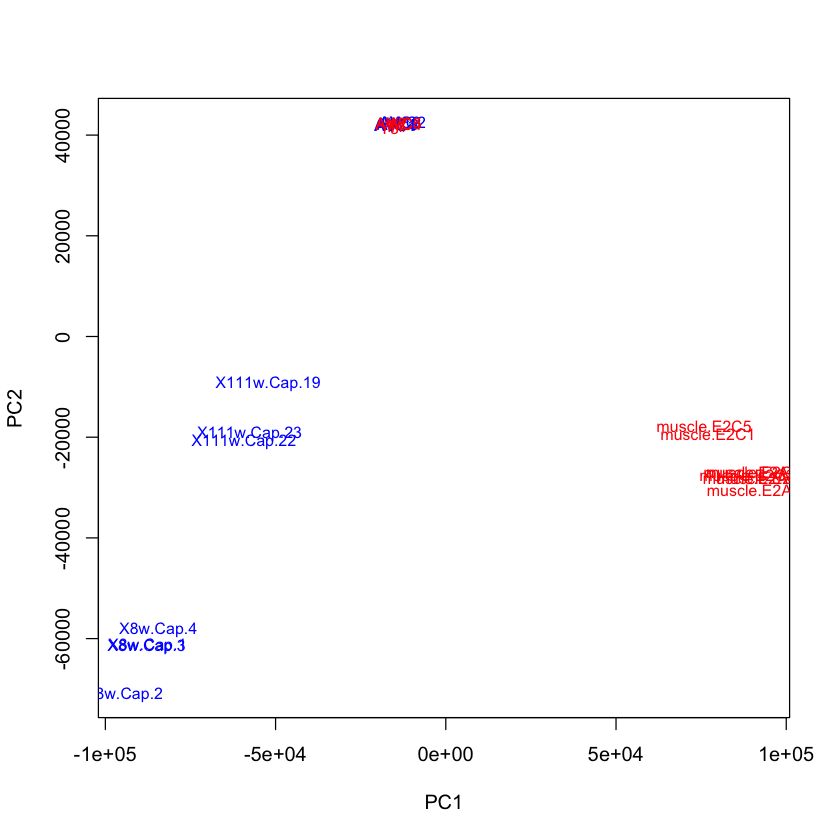

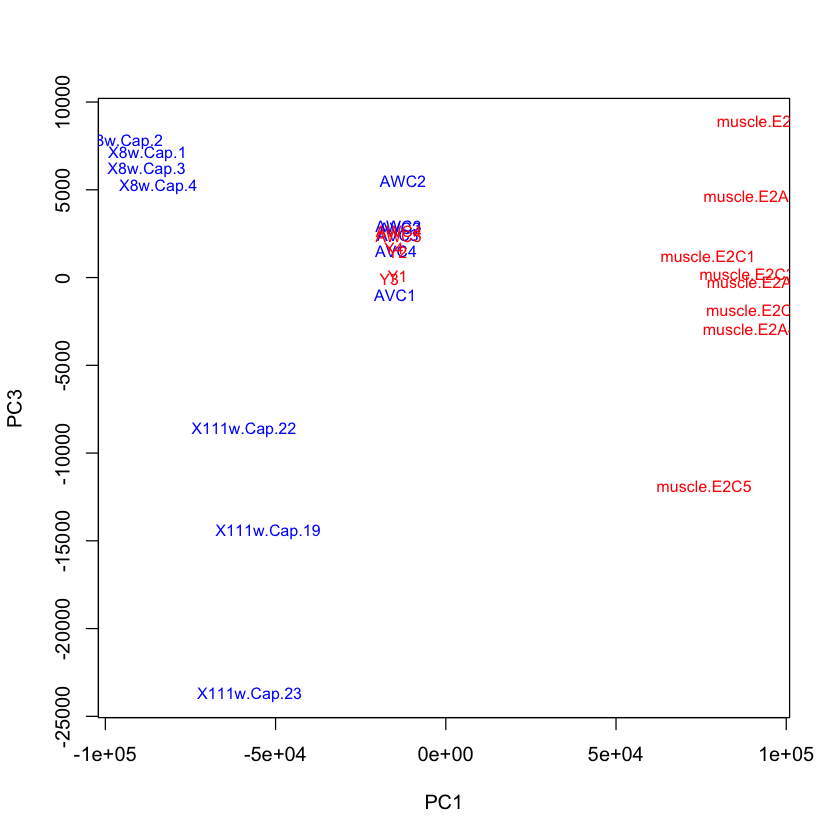

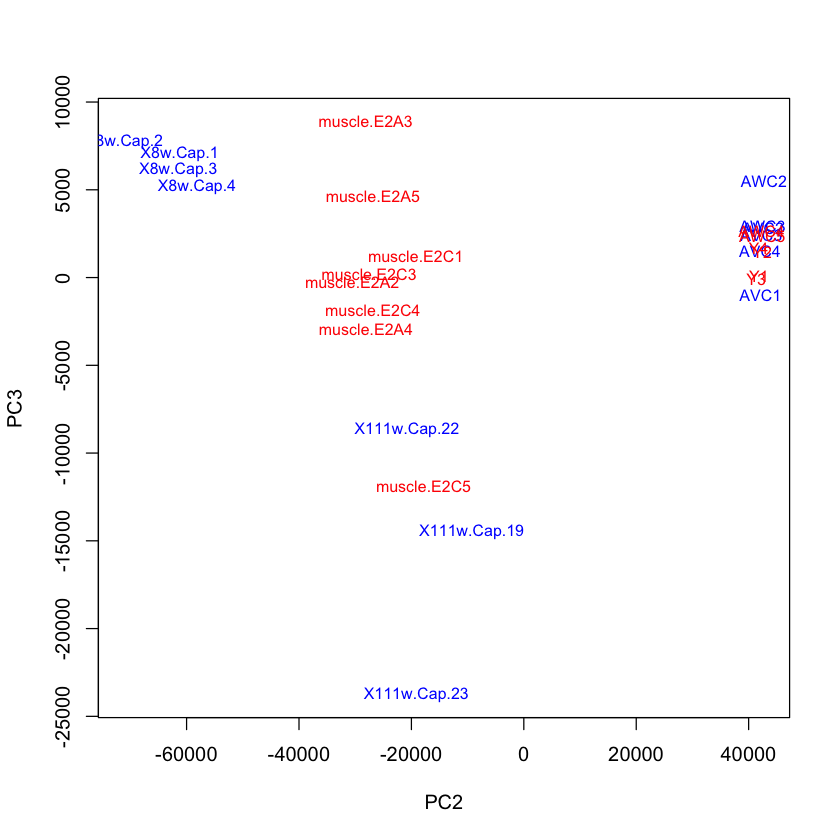

Warning message:
“The input is a data frame, convert it to the matrix.”


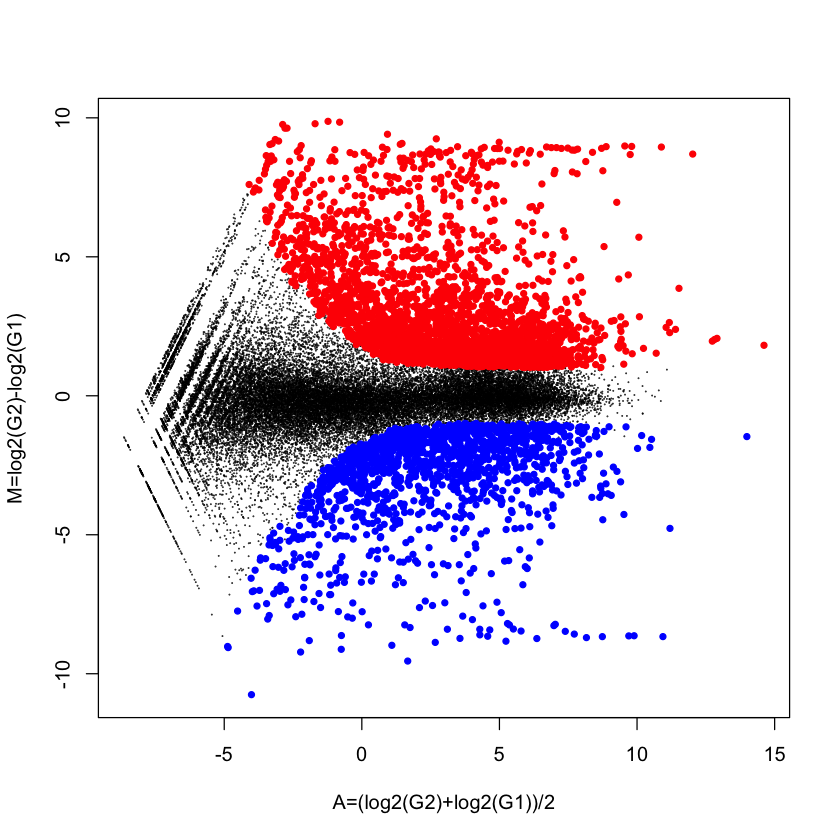

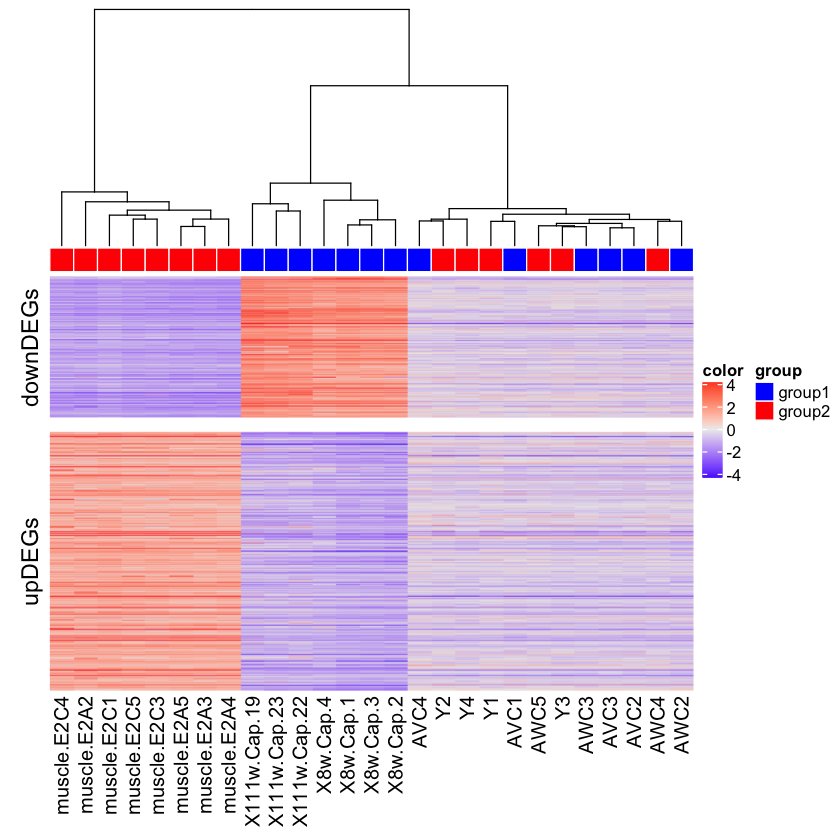

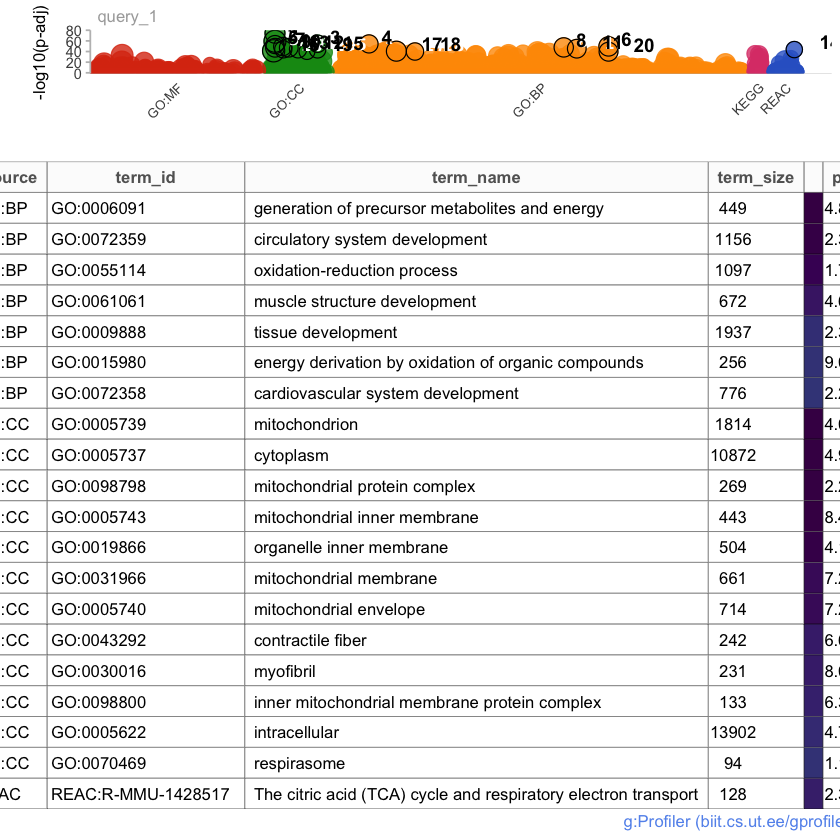

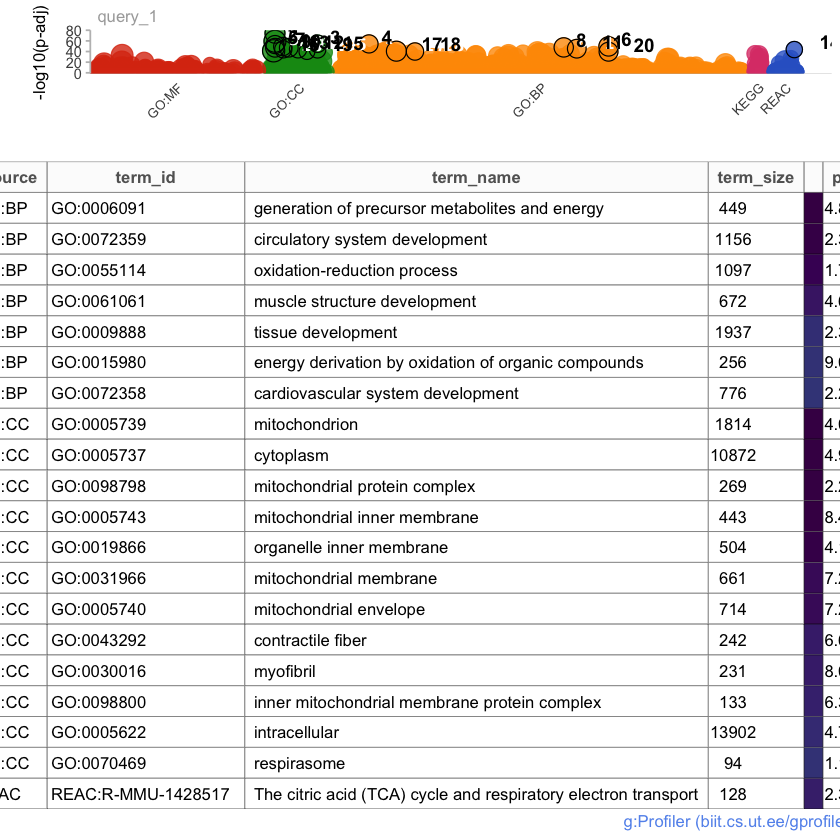

In [68]:
data <- Read_count("count_mouse.csv")
group <- c(rep("group1",13),rep("group2",14))
data <- Grouping(data, group)
group <-sort(group)
data <- Filtering(data, 0)
data <- Normalization(data,1000000)
Clustering(data)
PCA(data, group)
upDEG <- DEG(data, group, 0.05, 2, 'up')
downDEG <- DEG(data, group, 0.05, 2, 'down')
MAplot(data, group, 0.05, 2)
DrawHeatmap(data, group, upDEG, downDEG)
GO(upDEG, "mmusculus")